# Модель для предсказания уровня зарплатных ожиданий сотрудников

## Импорты

In [ ]:
!pip install catboost

In [3]:
# Вычисления и анализ
import numpy as np
import pandas as pd

# Хранение и загрузка постоянных данных
from google.colab import drive

# Визуализация данных
import seaborn as sns
from seaborn import heatmap
import matplotlib.pyplot as plt

# Утилиты и препроцессинг
import random
import warnings
from sklearn.utils import shuffle
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Модели и метрики
import sklearn
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae

# Воспроизводимость и продакшн
import pickle

## Исходные данные

In [4]:
drive.mount('/content/drive')
wdir = '/content/drive/My Drive/Courses/DataScience/DataScience/I_DIPLOMA/data'

Mounted at /content/drive


In [ ]:
raw_data = pd.read_excel(f'{wdir}/raw_data.xlsx')

In [ ]:
raw_data.head(3)

,Unnamed: 0,entrydate,title,position,gender,city,age,salary,experience,last_job,updated,link
0,0,2020-04-08,"Резюме Менеджер по продажам мебели, дизайнер-к...",Менеджер по продажам,Женщина,Москва,31,70,8.0,ООО ИНТЕХ,2020-04-08,https://hh.ru/resume/840fd6300000a252640039ed1...
1,1,2020-04-08,Резюме Специалист по работе с клиентами,Клиентский менеджер,Мужчина,Липецк,40,90,15.0,МДК,2020-04-08,https://hh.ru/resume/66498670000716a4250039ed1...
2,2,2020-04-08,"Резюме Супервайзер торговых представителей, ст...",Супервайзер,Мужчина,Самара,34,50,7.0,Ютф-дистрибьютор,2020-04-08,https://hh.ru/resume/70e7817700035195b70039ed1...


In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  3178 non-null   int64         
 1   entrydate   3178 non-null   datetime64[ns]
 2   title       3178 non-null   object        
 3   position    3178 non-null   object        
 4   gender      3178 non-null   object        
 5   city        3178 non-null   object        
 6   age         3178 non-null   int64         
 7   salary      3178 non-null   int64         
 8   experience  2522 non-null   float64       
 9   last_job    3178 non-null   object        
 10  updated     3178 non-null   datetime64[ns]
 11  link        3178 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 298.1+ KB


In [ ]:
raw_data.columns

Index(['Unnamed: 0', 'entrydate', 'title', 'position', 'gender', 'city', 'age',
       'salary', 'experience', 'last_job', 'updated', 'link'],
      dtype='object')

## Предобработка данных

In [ ]:
def data_prep(df_input):
  """Обрабатывает исходные данные"""
  df_output = df_input.copy()
  df_output['experience'] = df_output['experience'].fillna(
                            df_output['experience'].mean())
  df_output['experience'] = df_output['experience'].astype(np.int)
  df_output.drop([
                  'Unnamed: 0',
                  'title',
                  'entrydate',
                  'last_job',
                  'updated',
                  'link'],
                 axis=1,
                 inplace=True)
  
  return df_output

In [ ]:
# Посмотрим на подготовленные данные
data = data_prep(raw_data)
data.head()

,position,gender,city,age,salary,experience
0,Менеджер по продажам,Женщина,Москва,31,70,8
1,Клиентский менеджер,Мужчина,Липецк,40,90,15
2,Супервайзер,Мужчина,Самара,34,50,7
3,Коммерческий директор,Мужчина,Краснодар,47,60,10
4,Менеджер по продажам,Мужчина,Москва,43,50,11


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3178 entries, 0 to 3177
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3178 non-null   object
 1   gender      3178 non-null   object
 2   city        3178 non-null   object
 3   age         3178 non-null   int64 
 4   salary      3178 non-null   int64 
 5   experience  3178 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 149.1+ KB


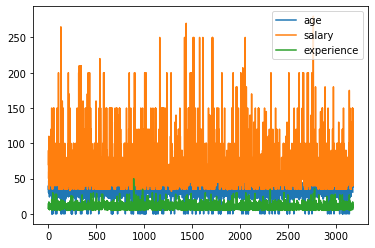

In [ ]:
# Посмотрим, есть ли в данных выбросы
data.plot();

In [ ]:
data[data['salary'] > 200]

,position,gender,city,age,salary,experience
130,Коммерческий директор,Мужчина,Москва,36,265,12
322,Менеджер по продажам,Мужчина,Москва,29,210,7
331,Менеджер по продажам,Мужчина,Москва,29,210,7
342,Менеджер по продажам,Мужчина,Москва,29,210,7
537,Региональный менеджер,Male,Moscow,35,220,10
1162,Менеджер по продажам,Мужчина,Москва,37,250,14
1421,Руководитель продаж,Мужчина,Москва,51,250,10
1429,Руководитель продаж,Мужчина,Москва,51,250,10
1438,Менеджер по продажам,Мужчина,Уфа,26,270,10
1511,Менеджер по продажам,Женщина,Москва,48,250,10


Пожалуй, все позиции кроме "Руководитель продаж" и "Коммерческий директор" с ожиданиями выше 200 тыс.руб - будут вносить "разлад" в наши данные. Удалим их

In [ ]:
 isx = data[
      (data['salary'] > 200) & 
      (data['position'] != 'Коммерческий директор') &
      (data['position'] != 'Руководитель продаж')].index

data = data.drop(data.index[isx])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3177
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3169 non-null   object
 1   gender      3169 non-null   object
 2   city        3169 non-null   object
 3   age         3169 non-null   int64 
 4   salary      3169 non-null   int64 
 5   experience  3169 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 173.3+ KB


## Feature Engineering

Обогатим наши данные численностью населения в городах проживания кандидатов, источник данных: https://zema.su/blog/polnyi-spisok-vsekh-gorodov-rossii-po-chislennosti-naseleniya

In [ ]:
cities = pd.read_excel(f'{wdir}/cities.xlsx')
cities = cities.drop('Н', axis=1)
cities.columns = ['city', 'population']
cities.head()

,city,population
0,Москва,11514330
1,Санкт-Петербург,4848742
2,Новосибирск,1473737
3,Екатеринбург,1350136
4,Нижний Новгород,1250615


In [ ]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1109 entries, 0 to 1108
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   city        1109 non-null   object
 1   population  1109 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 17.5+ KB


In [ ]:
# Добавим данные по численности к основному датасету
data_merged = data.merge(cities, how='left', left_on='city', right_on='city')
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330.0
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124.0
2,Супервайзер,Мужчина,Самара,34,50,7,1164896.0
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933.0
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330.0


In [ ]:
# Посмотрим % пропусков в столбце "population"
empty_values = data_merged['population'].isna().sum() / len (data_merged) * 100
print(f'{round(empty_values, 2)}%')

6.69%


In [ ]:
# Пропуски есть, но не критично много
# заполним их средними значениями
data_merged['population'] = data_merged['population'].fillna(
                            data_merged['population'].mean())
# И преобразуем float к int
data_merged['population'] = data_merged['population'].astype(np.int)
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3169 entries, 0 to 3168
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   position    3169 non-null   object
 1   gender      3169 non-null   object
 2   city        3169 non-null   object
 3   age         3169 non-null   int64 
 4   salary      3169 non-null   int64 
 5   experience  3169 non-null   int64 
 6   population  3169 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 198.1+ KB


In [ ]:
data_merged.head()

,position,gender,city,age,salary,experience,population
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124
2,Супервайзер,Мужчина,Самара,34,50,7,1164896
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330


In [ ]:
# Далее, преобразуем категориальные признаки в числовые
data_merged['gender_lbl'] = data_merged['gender'].apply(
                            lambda x: 1 if x == 'Мужчина' else 0
                            )
data_merged.head()

,position,gender,city,age,salary,experience,population,gender_lbl
0,Менеджер по продажам,Женщина,Москва,31,70,8,11514330,0
1,Клиентский менеджер,Мужчина,Липецк,40,90,15,508124,1
2,Супервайзер,Мужчина,Самара,34,50,7,1164896,1
3,Коммерческий директор,Мужчина,Краснодар,47,60,10,744933,1
4,Менеджер по продажам,Мужчина,Москва,43,50,11,11514330,1


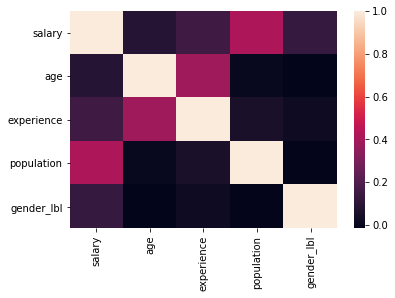

In [ ]:
# Посмотрим на зависимости между признаками
heatmap(
    data_merged[['salary', 
                 'age', 
                 'experience', 
                 'population', 
                 'gender_lbl']
                ].corr());

Как видно, самая сильная зависимость уровня ожиданий - от численности населения города проживания (в крупных городах ожидания явно выше). Возраст и опыт - сильно скоррелированы

In [ ]:
# Добавим фиктивные переменные к датасету из наименований позиций
# при помощи метода "One-hot encoding"
data_dummy = pd.get_dummies(data_merged.drop(['city', 'gender'], axis=1))
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Администратор,position_Водитель,position_Кам,position_Кассир,position_Кладовщик,position_Клиентский менеджер,position_Коммерческий директор,position_Курьер,position_Менеджер по закупкам,position_Менеджер по продажам,position_Менеджер по развитию,position_Мерчендайзер,position_Оператор,position_Помощник менеджера,position_Продавец-консультант,position_Региональный менеджер,position_Руководитель продаж,position_Специалист,position_Супервайзер,position_Территориальный менеджер,position_Товаровед,position_Торговый представитель,position_Управляющий магазином
0,31,70,8,11514330,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40,90,15,508124,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,50,7,1164896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,47,60,10,744933,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43,50,11,11514330,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
data_dummy.shape

(3169, 28)

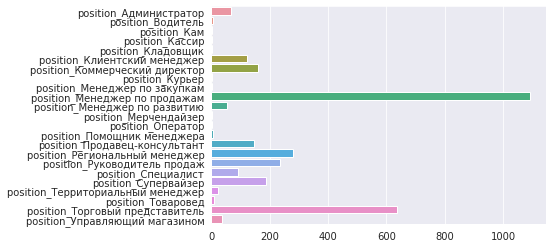

In [ ]:
# Посмотрим на частые позиции
db = data_dummy.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

In [ ]:
def transliterate(name):
   """
   Транслитерация наименований должностей
   """
   # Слоаврь с заменами
   slovar = {'а':'a','б':'b','в':'v','г':'g','д':'d','е':'e','ё':'e',
      'ж':'zh','з':'z','и':'i','й':'i','к':'k','л':'l','м':'m','н':'n',
      'о':'o','п':'p','р':'r','с':'s','т':'t','у':'u','ф':'f','х':'h',
      'ц':'c','ч':'cz','ш':'sh','щ':'scz','ъ':'','ы':'y','ь':'','э':'e',
      'ю':'u','я':'ja', 'А':'A','Б':'B','В':'V','Г':'G','Д':'D','Е':'E','Ё':'E',
      'Ж':'ZH','З':'Z','И':'I','Й':'I','К':'K','Л':'L','М':'M','Н':'N',
      'О':'O','П':'P','Р':'R','С':'S','Т':'T','У':'U','Ф':'F','Х':'H',
      'Ц':'C','Ч':'CZ','Ш':'SH','Щ':'SCH','Ъ':'','Ы':'y','Ь':'','Э':'E',
      'Ю':'U','Я':'YA',',':'','?':'',' ':'_','~':'','!':'','@':'','#':'',
      '$':'','%':'','^':'','&':'','*':'','(':'',')':'','-':'','=':'','+':'',
      ':':'',';':'','<':'','>':'','\'':'','"':'','\\':'','/':'','№':'',
      '[':'',']':'','{':'','}':'','ґ':'','ї':'', 'є':'','Ґ':'g','Ї':'i',
      'Є':'e', '—':''}
        
   # Циклически заменяем все буквы в строке
   for key in slovar:
      name = name.replace(key, slovar[key])
   return name

In [ ]:
# Заменим наименования на кирилице латиницей
new_names = []

for name in data_dummy.columns:
  new_name = transliterate(name)
  new_names.append(new_name)

print(new_names)

['age', 'salary', 'experience', 'population', 'gender_lbl', 'position_Administrator', 'position_Voditel', 'position_Kam', 'position_Kassir', 'position_Kladovsczik', 'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor', 'position_Kurer', 'position_Menedzher_po_zakupkam', 'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu', 'position_Merczendaizer', 'position_Operator', 'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant', 'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh', 'position_Specialist', 'position_Supervaizer', 'position_Territorialnyi_menedzher', 'position_Tovaroved', 'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom']


In [ ]:
data_dummy.columns = new_names
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,31,70,8,11514330,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40,90,15,508124,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,50,7,1164896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,47,60,10,744933,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43,50,11,11514330,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Сохраним подготовленные данные
data_dummy.to_excel(f'{wdir}/data_dummy.xlsx')

In [5]:
# Загрузим подготовленные данные
data_dummy = pd.read_excel(f'{wdir}/data_dummy.xlsx')
data_dummy = data_dummy.drop('Unnamed: 0', axis=1)
data_dummy.head()

,age,salary,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,31,70,8,11514330,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,40,90,15,508124,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,50,7,1164896,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,47,60,10,744933,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,43,50,11,11514330,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
# Отложим часть данных для тестирования,
# а часть тренировочных данных попробуем сбалансировать
random_seed = 42

X = data_dummy.drop(['salary'], axis=1)
y = data_dummy['salary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True,
    random_state=random_seed)

In [ ]:
# Посмотрим на структуру разбиения
x = PrettyTable()

x.field_names = ["Тип выборки", "Размерность"]
x.add_row(["initial", data_dummy.shape])
x.add_row(["X_train", X_train.shape])
x.add_row(["X_test", X_test.shape])
x.add_row(["y_train", y_train.shape])
x.add_row(["y_test", y_test.shape])
print(x)

+-------------+-------------+
| Тип выборки | Размерность |
+-------------+-------------+
|   initial   |  (3169, 28) |
|   X_train   |  (2535, 27) |
|    X_test   |  (634, 27)  |
|   y_train   |   (2535,)   |
|    y_test   |    (634,)   |
+-------------+-------------+


In [ ]:
X_train['salary'] = y_train
train = X_train

In [ ]:
# Данные по позициям очень неоднородны
# Случайным образом "перемешаем" и добавим частями
# уже имеющиеся данные в датасет

for i in range(30000):
  data_shuffle = shuffle(train).head(10)
  train = train.append(data_shuffle)

len(train)

302535

In [ ]:
train.columns

Index(['age', 'experience', 'population', 'gender_lbl',
       'position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom',
       'salary'],
      dtype='object')

In [ ]:
# Теперь выберем по 400 случайных строк по каждой позиции

for_train = pd.DataFrame()

for i in train.columns[4:-1]:
  data_filtred = train[train[i] == 1].head(400)
  for_train = for_train.append(data_filtred)
  for_train.index = range(len(for_train.index))

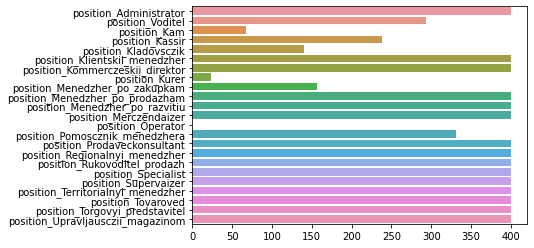

In [ ]:
# Снова посмотрим на позиции
db = for_train.drop(['age',	'salary',	'experience',	
                       'population',	'gender_lbl'], axis=1)

sns.barplot(x = db.sum(), 
            y = db.sum().index);

In [ ]:
# Сохраним подготовленные данные
for_train.to_excel(f'{wdir}/for_train.xlsx')

In [8]:
# Загрузим подготовленные данные
for_train = pd.read_excel(f'{wdir}/for_train.xlsx')
for_train = for_train.drop('Unnamed: 0', axis=1)
for_train = shuffle(for_train, random_state=42)
for_train.head()

,age,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom,salary
2952,0,5,11514330,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,37
1634,53,10,1250615,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,70
2622,25,5,11514330,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,70
7048,32,11,1143546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,50
6732,43,7,111087,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,40


In [ ]:
for_train.shape

(7250, 28)

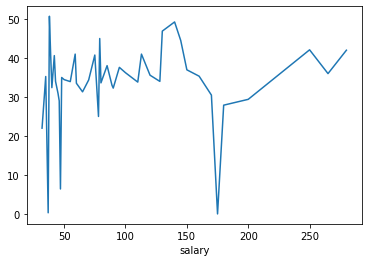

In [ ]:
# Возраст - доход
for_train.groupby('salary')['age'].mean().plot();

Наблюдается некоторый рост ожиданий при росте возраста, однако и молодые люди (до 30-ти лет), также претендуют на высокий доход

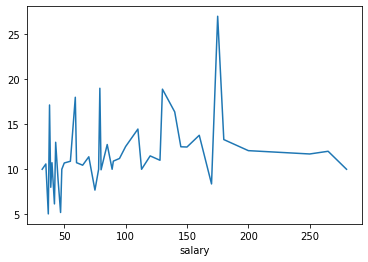

In [ ]:
# Опыт - доход
for_train.groupby('salary')['experience'].mean().plot();

Ожидаемо, что возраст и опыт скоррелированы, оценим это на стадии отбора признаков

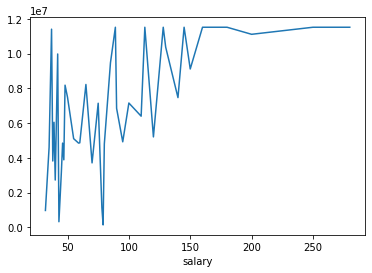

In [ ]:
# Размер города - доход
for_train.groupby('salary')['population'].mean().plot();

Численность города явно влияет на ожидания. Наиболее высокий уровень ЗП ожидают жители крупных городов. Среди малых городов ожидания ниже.

In [9]:
y_train = for_train['salary'].values
X_train = for_train.drop(['salary'], axis=1)

In [10]:
X = X_train.append(X_test)
y = pd.DataFrame(y_train).append(pd.DataFrame(y_test))

In [11]:
data_rebuilt = X
data_rebuilt['salary'] = y.values

In [ ]:
# Посмотрим на структуру разбиения
x = PrettyTable()

x.field_names = ["Тип выборки", "Размерность"]
x.add_row(["Full", data_rebuilt.shape])
x.add_row(["X_train", X_train.shape])
x.add_row(["X_test", X_test.shape])
x.add_row(["y_train", y_train.shape])
x.add_row(["y_test", y_test.shape])
print(x)

+-------------+-------------+
| Тип выборки | Размерность |
+-------------+-------------+
|     Full    |  (7884, 28) |
|   X_train   |  (7250, 27) |
|    X_test   |  (634, 27)  |
|   y_train   |   (7250,)   |
|    y_test   |    (634,)   |
+-------------+-------------+


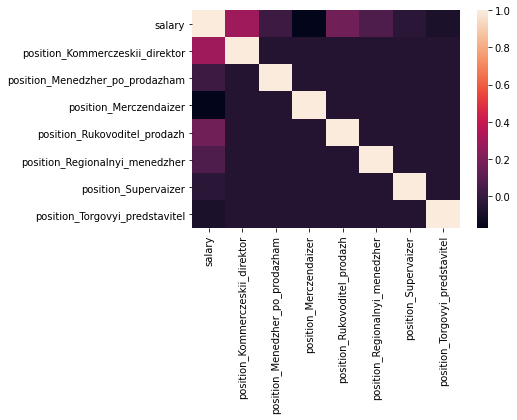

In [ ]:
heatmap(for_train[['salary',
                   'position_Kommerczeskii_direktor',
                   'position_Menedzher_po_prodazham',
                   'position_Merczendaizer',
                   'position_Rukovoditel_prodazh',
                   'position_Regionalnyi_menedzher',
                   'position_Supervaizer',
                   'position_Torgovyi_predstavitel'
                    ]].corr());

Также на примере мы видим явную зависимость между статусными позициями, такими как "Коммерческий директор" и "Руководитель продаж" и уровнем их ожиданий по доходу

## Baseline - тренируем наивную модель

"Always start with a stupid model, no exceptions..."

In [12]:
# Фиксируем гиперпараметры
random_seed = 42
splits = 5

Для baseline будем использовать простейшее предсказание на основе средний значений salary по каждой позиции

In [ ]:
def baseline():
  """Базовая модель на основе предсказания среднего 
  значения по признакам: возраст, пол, опыт, город"""
  # X_train, X_test, y_train, y_test = data_split(data)
  X_train['salary'] = y_train
  # y = data['salary'].values

  predict = []

  for index, row in pd.DataFrame(X_test).iterrows():
    results = X_train.query(f'age == {row[0]} \
                            and experience == {row[1]} \
                            and population == {row[2]} \
                            and gender_lbl == {row[3]} \
                            ')['salary'].mean()
    predict.append(results)
  

  predict = pd.DataFrame(predict)
  predict = predict.fillna(predict.mean())
  error = mae(y_test, predict)

  print('MAE:', error, 'MAPE:', error / data_dummy['salary'].mean())

  fig, ax = plt.subplots()
  ax.scatter(y_test, predict, edgecolors=(0,0,0))
  ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
  ax.set_xlabel('Measured')
  ax.set_ylabel('Predicted')
  plt.show()

MAE: 22.883412998943516 MAPE: 0.356993589422017


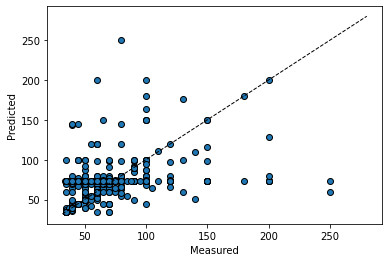

In [ ]:
baseline()

Метрики `mae` и `mape` выберем в связи с их высокой интуитивностью, ведь все понимают, что ошибка модели в 1-2 тыс.р - приемлемый результат, а в 5-10 тыс.р при средней ожидаемой зарплате в 65 тыс.р. - это достаточно много.

## Подготовка и построение модели

### Разбиение выборки и кросс-валидация

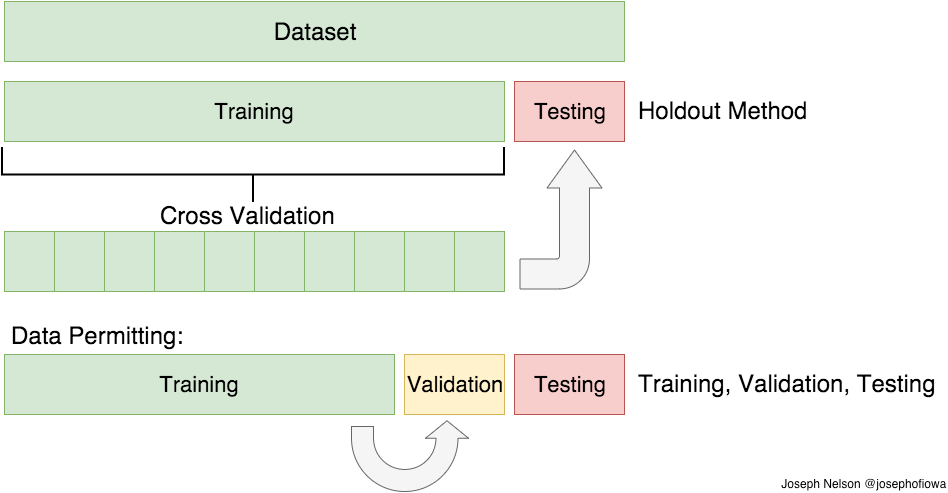

Обучение модели на одной разбивке данных, особенно при небольшом их количестве, как в нашем случае - является методологической ошибкой. Поэтому, сделаем разбиение данных на фолды и кросс-валидацию

In [ ]:
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

In [13]:
def cross_val(model):
  """Скоринг кросс-валидации данных"""
  # X = data.drop(['salary'], axis=1)
  # y = data['salary'].values

  cv_score = cross_val_score(model, 
                              X, y, 
                              cv=splits,
                              scoring='neg_mean_absolute_error',
                              n_jobs=-1)
  return abs(cv_score.mean())

In [ ]:
# Начнем с модели линейной регрессии
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
cross_val( model_lr )

17.418015682776698

In [ ]:
def cross_val_fig(model):
  """Визуализация прогноза кросс-валидации данных"""
  # X = data.drop(['salary'], axis=1)
  # y = data['salary'].values

  predicted = cross_val_predict(model, 
                                X, y, 
                                cv=splits)
  
  error = mae(y, predicted)
  # cross_val_predict возвращает массив размерности `y`, где каждое значение
  # где каждый прогноз получен методом кросс-валидации:
  
  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y, predicted, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  
  print('MAE:', error, 'MAPE:', error / data_dummy['salary'].mean())
  plt.show()

MAE: 17.418265187566536 MAPE: 0.27173433486958537


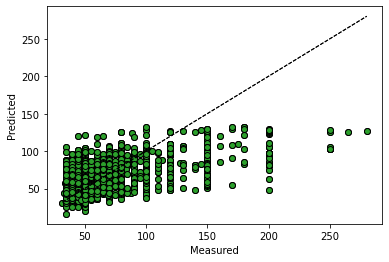

In [ ]:
model_lr = LinearRegression()
cross_val_fig(model_lr)

Приближение линией - не работает. На графике видно, что аппроксимирующей способности модели линейной регрессии недостаточно, чтобы описать зависимости в данных. Результат хуже Baseline. Требуется усложнение модели

### Сравнительное тестирование различных моделей с базовыми параметрами

In [14]:
def review_models(data):
  """Обзор метрики MAE / MAPE некоторых моделей на
  стандартных настройках"""

  y_train = data['salary'].values
  X_train = data.drop(['salary'], axis=1)

  mean_salary = data_dummy['salary'].mean()

  # X_train, X_test, y_train, y_test = data_split(data)
  
  # CatBoost
  model_catboost = CatBoostRegressor(random_state=random_seed)
  model_catboost.fit(X_train, y_train, silent=True)
  y_catboost = model_catboost.predict(X_test)
  mae_catboost = mae(y_test, y_catboost)

  # Lightgbm
  model_lightgbm = LGBMRegressor(random_state=random_seed)
  model_lightgbm.fit(X_train, y_train)
  y_lightgbm = model_lightgbm.predict(X_test)
  mae_lightgbm = mae(y_test, y_lightgbm)

  # XGBRegressor
  model_xgb = XGBRegressor(random_state=random_seed)
  model_xgb.fit(X_train, y_train)
  y_xgb = model_xgb.predict(X_test)
  mae_xgb = mae(y_test, y_xgb)

  # RandomForest
  model_rf = RandomForestRegressor(random_state=random_seed)
  model_rf.fit(X_train, y_train)
  y_rf = model_rf.predict(X_test)
  mae_rf = mae(y_test, y_rf)

  #ExtraTrees
  model_etr = ExtraTreesRegressor(random_state=random_seed)
  model_etr.fit(X_train, y_train)
  y_etr = model_etr.predict(X_test)
  mae_etr = mae(y_test, y_etr)
  
  # Таблица итогового сравнения
  x = PrettyTable()
  x.field_names = ["Regressor", "MAE", "MAPE"]
  x.add_row(["CatBoost", mae_catboost, mae_catboost / mean_salary])
  x.add_row(["LGBM", mae_lightgbm, mae_lightgbm / mean_salary])
  x.add_row(["RandomForest", mae_rf, mae_rf / mean_salary])
  x.add_row(["XGBoost", mae_xgb, mae_xgb / mean_salary])
  x.add_row(["ExtraTrees", mae_etr, mae_etr / mean_salary])

  print(x.get_string(sortby="MAPE"))


In [ ]:
# Обзор результатов
warnings.filterwarnings('ignore')
review_models(for_train)

[05:07:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
+--------------+--------------------+---------------------+
|  Regressor   |        MAE         |         MAPE        |
+--------------+--------------------+---------------------+
|   XGBoost    | 15.671005778508231 |  0.2444761453626305 |
|     LGBM     | 15.684422392756128 |  0.2446854517837692 |
|   CatBoost   | 15.879395552015907 | 0.24772713826507828 |
|  ExtraTrees  | 16.131642838455473 |  0.2516623320323796 |
| RandomForest | 16.300638381019535 | 0.25429875367713384 |
+--------------+--------------------+---------------------+


### Отбор признаков

In [ ]:
# Посмотрим на значимость признаков для модели


def feature_importance(data):  
  """Оценка значимости признаков"""

  # X_train, X_test, y_train, y_test = data_split(data)

  #XGBreg
  model = XGBRegressor(random_state=random_seed)
  model.fit(X_train, y_train)

  # Значения признаков
  r = permutation_importance(model, 
                            X_test, y_test,
                            n_repeats=3,
                            random_state=random_seed)
  f_imp = []
  f_imp_list = []  # Only columns
  for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
      f_imp.append(
          f"{data.columns[i]:<8} \
          {r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")
      
      f_imp_list.append(data.columns[i])
  
  return f_imp, f_imp_list

In [ ]:
f_imp = feature_importance(data_rebuilt)
f_imp[0]

[07:41:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


['population           0.370 +/- 0.015',
 'position_Kommerczeskii_direktor           0.243 +/- 0.014',
 'position_Rukovoditel_prodazh           0.090 +/- 0.010',
 'gender_lbl           0.042 +/- 0.005',
 'position_Regionalnyi_menedzher           0.037 +/- 0.007',
 'position_Menedzher_po_razvitiu           0.018 +/- 0.006',
 'position_Menedzher_po_prodazham           0.011 +/- 0.001',
 'position_Prodaveckonsultant           0.010 +/- 0.001',
 'position_Klientskii_menedzher           0.004 +/- 0.001',
 'position_Torgovyi_predstavitel           0.003 +/- 0.002']

In [ ]:
f_imp[1]

['population',
 'position_Kommerczeskii_direktor',
 'position_Rukovoditel_prodazh',
 'gender_lbl',
 'position_Regionalnyi_menedzher',
 'position_Menedzher_po_razvitiu',
 'position_Menedzher_po_prodazham',
 'position_Prodaveckonsultant',
 'position_Klientskii_menedzher',
 'position_Torgovyi_predstavitel']

In [ ]:
df = for_train.copy()
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

,salary,age,experience,population,gender_lbl,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
2952,37,0,5,11514330,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1634,70,53,10,1250615,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2622,70,25,5,11514330,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7048,50,32,11,1143546,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6732,40,43,7,111087,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
for i in range(df.shape[1]):
  if i > 2:
    print(f'Features Split: [:{i}]')
    review_models(df.iloc[:, :i])

### Обучение модели XGBR с оптимизацией гиперпараметров

In [ ]:
# GridSearchCV обладает встроенными метриками и позволяет
# осуществлять кросс-валидацию


def train_xgbr(data):
  """Обучает модель регрессии XGBR"""
  
  mean_salary = data_dummy['salary'].mean()
  # X = data.drop(['salary'], axis=1)
  # y = data['salary'].values
  y_train = data['salary'].values
  X_train = data.drop(['salary'], axis=1)
  
  # Описание модели
  model = XGBRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      'n_estimators': [20, 30, 50, 100, 300],
      # 'max_depth': [int],
      'learning_rate': [0.1, 1, 1.2],
      'verbosity': [0.1, 1, 1.2],
      'objective': ['reg:squarederror'],
      'booster': ['gbtree', 'gblinear', 'dart'],
      # 'tree_method': [str],
      # 'gamma': [float],
      # 'min_child_weight': [float],
      'colsample_bytree': [0.3, 1],
      # 'colsample_bylevel': [float],
      # 'colsample_bynode': [],
      # 'reg_alpha': [0.2],
      # 'reg_lambda': [float],
      # 'scale_pos_weight': [float],
      'base_score': [0.1, 0.5, 1]
      }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = XGBRegressor(
      random_state=random_seed,
      n_estimators=best_params['n_estimators'],
      # max_depth=best_params['max_depth'],
      learning_rate=best_params['learning_rate'],
      verbosity=best_params['verbosity'],
      objective=best_params['objective'],
      booster=best_params['booster'],
      # tree_method=best_params['tree_method'],
      # gamma=best_params['gamma'],
      # min_child_weight=best_params['min_child_weight'],
      colsample_bytree=best_params['colsample_bytree'],
      # colsample_bylevel=best_params['colsample_bylevel'],
      # colsample_bynode=best_params['colsample_bynode'],
      # reg_alpha=best_params['reg_alpha'],
      # reg_lambda=best_params['reg_lambda'],
      # scale_pos_weight=best_params['scale_pos_weight'],
      base_score=best_params['base_score']
      )
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Лучшие параметры: {'base_score': 0.5, 'booster': 'gblinear', 'colsample_bytree': 0.3, 'learning_rate': 1, 'n_estimators': 100, 'objective': 'reg:squarederror', 'verbosity': 1}
Обучение модели на лучших параметрах...
MAE: 18.577099490240922 MAPE: 0.289812775234936


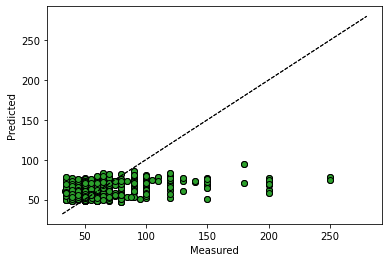

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [ ]:
train_xgbr(for_train)

### Обучение модели LGBM с оптимизацией гиперпараметров

In [ ]:
def train_lgbm(data):
  """Обучает модель регрессии LGBM"""
  
  mean_salary = data_dummy['salary'].mean()
  # X = data.drop(['salary'], axis=1)
  # y = data['salary'].values
  y_train = data['salary'].values
  X_train = data.drop(['salary'], axis=1)
  
  # Описание модели
  model = LGBMRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      'boosting_type': ['gbdt'], 
      'num_leaves': [5, 10, 15], 
      'max_depth': [-1], 
      'learning_rate': [0.05, 0.1, 1], 
      'n_estimators': [600], 
      'subsample_for_bin': [200000], 
      'objective': ['regression'], 
      'class_weight': [None], 
      'min_split_gain': [0.0], 
      'min_child_weight': [1e-3], 
      'min_child_samples': [3],
      'subsample': [1.0], 
      'subsample_freq': [0], 
      'colsample_bytree': [1.0], 
      'reg_alpha': [0.0], 
      'reg_lambda': [0.0],
      'n_jobs': [-1], 
      'importance_type': ['split']
  }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = LGBMRegressor(
      boosting_type=best_params['boosting_type'], 
      num_leaves=best_params['num_leaves'], 
      max_depth=best_params['max_depth'], 
      learning_rate=best_params['learning_rate'], 
      n_estimators=best_params['n_estimators'], 
      subsample_for_bin=best_params['subsample_for_bin'], 
      objective=best_params['objective'], 
      class_weight=best_params['class_weight'], 
      min_split_gain=best_params['min_split_gain'], 
      min_child_weight=best_params['min_child_weight'], 
      min_child_samples=best_params['min_child_samples'], 
      subsample=best_params['subsample'], 
      subsample_freq=best_params['subsample_freq'], 
      colsample_bytree=best_params['colsample_bytree'], 
      reg_alpha=best_params['reg_alpha'], 
      reg_lambda=best_params['reg_lambda'], 
      random_state=random_seed, 
      n_jobs=- 1, 
      silent=True, 
      importance_type=best_params['importance_type']
  )
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Лучшие параметры: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 3, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 600, 'n_jobs': -1, 'num_leaves': 5, 'objective': 'regression', 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}
Обучение модели на лучших параметрах...
MAE: 16.112324779550953 MAPE: 0.25136095989050067


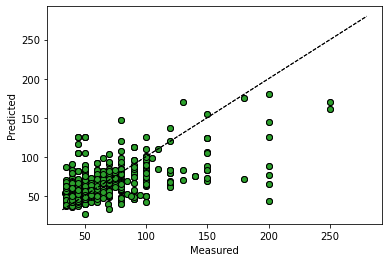

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=600, n_jobs=-1, num_leaves=5, objective='regression',
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
train_lgbm(for_train)

### Обучение модели CatBoost с оптимизацией гиперпараметров

In [55]:
def train_catboost(data):
  """Обучает модель регрессии CBR"""
  
  mean_salary = data_dummy['salary'].mean()
  # X = data.drop(['salary'], axis=1)
  # y = data['salary'].values
  y_train = data['salary'].values
  X_train = data.drop(['salary'], axis=1)
  
  # Описание модели
  model = CatBoostRegressor(random_state=random_seed)
  
  # Оптимизатор гиперпараметров
  params = {
      'iterations': [1000], 
      'learning_rate': [0.1],
      # 'depth': None, 
      'l2_leaf_reg': [3.0],
      # 'model_size_reg': None, 
      # 'rsm': None,
      # 'loss_function': ['MAE'], 
      # 'border_count': None,
      # 'feature_border_type': None,
      # 'per_float_feature_quantization': None,
      # 'input_borders': None, 
      # 'output_borders': None,
      # 'fold_permutation_block': None, 
      # 'od_pval': None,
      # 'od_wait': None, 
      # 'od_type': None,
      # 'nan_mode': None,
      # 'counter_calc_method': [],
      'leaf_estimation_iterations': [5, 10, 100],
      'leaf_estimation_method': ['Gradient'],
      # 'thread_count': None,
      # 'random_seed': None,
      # 'use_best_model': True,
      # 'best_model_min_trees': None,
      # 'verbose': None,
      # 'logging_level': None,
      # 'metric_period': None,
      # 'ctr_leaf_count_limit': None,
      # 'store_all_simple_ctr': None,
      # 'max_ctr_complexity': None,
      # 'has_time': None,
      # 'allow_const_label': None,
      # 'one_hot_max_size': None,
      # 'random_strength': None,
      # 'name': None,
      # 'ignored_features': None,
      # 'train_dir': None,
      # 'custom_metric': None,
      # 'eval_metric': None,
      # 'bagging_temperature': None,
      # 'save_snapshot': None,
      # 'snapshot_file': None,
      # 'snapshot_interval': None,
      # 'fold_len_multiplier': None,
      # 'used_ram_limit': None,
      # 'gpu_ram_part': None,
      # 'pinned_memory_size': None,
      # 'allow_writing_files': None,
      # 'final_ctr_computation_mode': None,
      # 'approx_on_full_history': None,
      'boosting_type': ['Plain'],
      # 'simple_ctr': None,
      # 'combinations_ctr': None,
      # 'per_feature_ctr': None,
      # 'ctr_target_border_count': None,
      # 'task_type': None,
      # 'device_config': None,                        
      # 'devices': None,
      'bootstrap_type': ['MVS'],
      # 'subsample': None,                        
      # 'sampling_unit': None,
      # 'dev_score_calc_obj_block_size': None,
      # 'max_depth': None,
      # 'n_estimators': [1000],
      # 'num_boost_round': None,
      # 'num_trees': None,
      # 'colsample_bylevel': None,
      # 'reg_lambda': None,
      # 'objective': None,
      # 'eta': None,
      # 'max_bin': None,
      # 'gpu_cat_features_storage': None,
      # 'data_partition': None,
      # 'metadata': None,
      # 'early_stopping_rounds': None,
      # 'cat_features': None,
      # 'grow_policy': ['SymmetricTree', 'Depthwise'],
      # 'min_data_in_leaf': None,
      # 'min_child_samples': None,
      # 'max_leaves': None,
      # 'num_leaves': [5, 30, 50],
      # 'score_function': None,
      # 'leaf_estimation_backtracking': None,
      # 'ctr_history_unit': None,
      # 'monotone_constraints': None,
      # 'feature_weights': None,
      # 'penalties_coefficient': None,
      # 'first_feature_use_penalties': None,
      # 'model_shrink_rate': None,
      # 'model_shrink_mode': None,
      # 'langevin': None,
      # 'diffusion_temperature': None,
      # 'boost_from_average': None
  }

  clf = GridSearchCV(model, 
                     params) # Кросс-валидация на n-folds
  
  search = clf.fit(X, y)
  best_params = search.best_params_
  print('Лучшие параметры:', best_params)
  print('Обучение модели на лучших параметрах...')

  # Обучение модели с оптимальными гиперпараметрами
  best_model = CatBoostRegressor(
      iterations=best_params['iterations'], 
      learning_rate=best_params['learning_rate'],
      # depth=best_params['depth'], 
      l2_leaf_reg=best_params['l2_leaf_reg'],
      # model_size_reg=best_params['model_size_reg'], 
      # rsm=best_params['rsm'],
      # loss_function=best_params['loss_function'], 
      # border_count=best_params['border_count'],
      # feature_border_type=best_params['feature_border_type'],
      # per_float_feature_quantization=best_params['per_float_feature_quantization'],
      # input_borders=best_params['input_borders'], 
      # output_borders=best_params['output_borders'],
      # fold_permutation_block=best_params['fold_permutation_block'], 
      # od_pval=best_params['od_pval'],
      # od_wait=best_params['od_wait'], 
      # od_type=best_params['od_type'],
      # nan_mode=best_params['nan_mode'],
      # counter_calc_method=best_params['counter_calc_method'],
      leaf_estimation_iterations=best_params['leaf_estimation_iterations'],
      leaf_estimation_method=best_params['leaf_estimation_method'],
      # thread_count=best_params['thread_count'],
      # random_seed=best_params['random_seed'],
      # use_best_model=best_params['use_best_model'],
      # best_model_min_trees=best_params['best_model_min_trees'],
      # verbose=best_params['verbose'],
      silent=True,
      # logging_level=best_params['logging_level'],
      # metric_period=best_params['metric_period'],
      # ctr_leaf_count_limit=best_params['ctr_leaf_count_limit'],
      # store_all_simple_ctr=best_params['store_all_simple_ctr'],
      # max_ctr_complexity=best_params['max_ctr_complexity'],
      # has_time=best_params['has_time'],
      # allow_const_label=best_params['allow_const_label'],
      # one_hot_max_size=best_params['one_hot_max_size'],
      # random_strength=best_params['random_strength'],
      # name=best_params['name'],
      # ignored_features=best_params['ignored_features'],
      # train_dir=best_params['train_dir'],
      # custom_metric=best_params['custom_metric'],
      # eval_metric=best_params['eval_metric'],
      # bagging_temperature=best_params['bagging_temperature'],
      # save_snapshot=best_params['save_snapshot'],
      # snapshot_file=best_params['snapshot_file'],
      # snapshot_interval=best_params['snapshot_interval'],
      # fold_len_multiplier=best_params['fold_len_multiplier'],
      # used_ram_limit=best_params['used_ram_limit'],
      # gpu_ram_part=best_params['gpu_ram_part'],
      # pinned_memory_size=best_params['pinned_memory_size'],
      # allow_writing_files=best_params['allow_writing_files'],
      # final_ctr_computation_mode=best_params['final_ctr_computation_mode'],
      # approx_on_full_history=best_params['approx_on_full_history'],
      boosting_type=best_params['boosting_type'],
      # simple_ctr=best_params['simple_ctr'],
      # combinations_ctr=best_params['combinations_ctr'],
      # per_feature_ctr=best_params['per_feature_ctr'],
      # ctr_target_border_count=best_params['ctr_target_border_count'],
      # task_type=best_params['task_type'],
      # device_config=best_params['device_config'],                        
      # devices=best_params['devices'],
      bootstrap_type=best_params['bootstrap_type'],
      # subsample=best_params['subsample'],                        
      # sampling_unit=best_params['sampling_unit'],
      # dev_score_calc_obj_block_size=best_params['dev_score_calc_obj_block_size'],
      # max_depth=best_params['max_depth'],
      # n_estimators=best_params['n_estimators'],
      # num_boost_round=best_params['num_boost_round'],
      # num_trees=best_params['num_trees'],
      # colsample_bylevel=best_params['colsample_bylevel'],
      random_state=random_seed,
      # reg_lambda=best_params['reg_lambda'],
      # objective=best_params['objective'],
      # eta=best_params['eta'],
      # max_bin=best_params['max_bin'],
      # gpu_cat_features_storage=best_params['gpu_cat_features_storage'],
      # data_partition=best_params['data_partition'],
      # metadata=best_params['metadata'],
      # early_stopping_rounds=best_params['early_stopping_rounds'],
      # cat_features=best_params['cat_features'],
      # grow_policy=best_params['grow_policy'],
      # min_data_in_leaf=best_params['min_data_in_leaf'],
      # min_child_samples=best_params['min_child_samples'],
      # max_leaves=best_params['max_leaves'],
      # num_leaves=best_params['num_leaves'],
      # score_function=best_params['score_function'],
      # leaf_estimation_backtracking=best_params['leaf_estimation_backtracking'],
      # ctr_history_unit=best_params['ctr_history_unit'],
      # monotone_constraints=best_params['monotone_constraints'],
      # feature_weights=best_params['feature_weights'],
      # penalties_coefficient=best_params['penalties_coefficient'],
      # first_feature_use_penalties=best_params['first_feature_use_penalties'],
      # model_shrink_rate=best_params['model_shrink_rate'],
      # model_shrink_mode=best_params['model_shrink_mode'],
      # langevin=best_params['langevin'],
      # diffusion_temperature=best_params['diffusion_temperature'],
      # boost_from_average=best_params['boost_from_average']
  )
  
  best_model.fit(X_train, y_train)
  
  # Предсказание на основании обученной модели
  y_pred = best_model.predict(X_test)

  # Метрика качества mse
  error = mae(y_test, y_pred)
  
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

  return best_model

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 20.8080649	total: 36.6ms	remaining: 7.28s
5:	learn: 18.8627613	total: 44.1ms	remaining: 7.3s
6:	learn: 17.0435906	total: 51.3ms	remaining: 7.28s
7:	learn: 15.4700342	total: 66.8ms	remaining: 8.28s
8:	learn: 14.0330820	total: 75.9ms	remaining: 8.35s
9:	learn: 12.7133052	total: 82.1ms	remaining: 8.12s
10:	learn: 11.5180090	total: 88.2ms	remaining: 7.93s
11:	learn: 10.4494238	total: 95.6ms	remaining: 7.87s
12:	learn: 9.4790940	total: 102ms	remaining: 7.72s
13:	learn: 8.6420287	total: 111ms	remaining: 7.85s
14:	learn: 7.8694404	total: 117ms	remaining: 7.71s
15:	learn: 7.1550767	total: 124ms	remaining: 7.6s
16:	learn: 6.4882811	total: 130ms	remaining: 7.5s
17:	learn: 5.8984603	total: 139ms	remaining: 7.56s
18:	learn: 5.3576935	total: 145ms	remaining: 7.5s
19:	learn: 4.8780493	total: 152ms	remaining: 7.46s
20:	learn: 4.4665819	total: 160ms	remaining: 7.45s
21:	learn: 4.0902780	total: 168ms	remaining: 7.48s
22:	lear

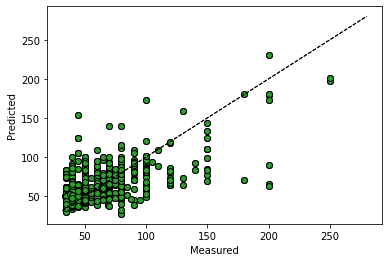

In [56]:
train_catboost(for_train)

### Стэкинг

In [57]:
def stack(data):
  """Стэкинг наиболее сильных из слабых моделей"""
  mean_salary = data_dummy['salary'].mean()
  # X = data.drop(['salary'], axis=1)
  # y = data['salary'].values
  y_train = data['salary'].values
  X_train = data.drop(['salary'], axis=1)

  estimators = [
      ('XGBR', XGBRegressor(
          base_score=0.5, booster='gblinear', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.3, gamma=0,
          importance_type='gain', learning_rate=1, max_delta_step=0,
          max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
          n_jobs=1, nthread=None, objective='reg:squarederror',
          random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=None, subsample=1, verbosity=1
      )),
      ('LGBM', LGBMRegressor(
          boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          importance_type='split', learning_rate=0.1, max_depth=-1,
          min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=600, n_jobs=-1, num_leaves=5, objective='regression',
          random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=0
      )),
      ('CATR', CatBoostRegressor(random_state=random_seed, silent=True,
          boosting_type='Plain', bootstrap_type='MVS', iterations=1000, 
          l2_leaf_reg=3.0, leaf_estimation_iterations=10, 
          leaf_estimation_method='Gradient', learning_rate=0.1
      ))
  ]

  model_stack = StackingRegressor(
      estimators=estimators,
      final_estimator=XGBRegressor(random_state=random_seed)
  )
      
  model_stack.fit(X_train, y_train)
  y_pred = model_stack.predict(X_test)
  error = mae(y_test, y_pred)
  print('MAE:', error, 'MAPE:', error / mean_salary)

  fig, ax = plt.subplots()
  for color in ['tab:orange', 'tab:green']:
    ax.scatter(y_test, y_pred, edgecolors=(0,0,0), c=color)
    ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=1)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
  plt.show()

[19:49:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 16.097532813857406 MAPE: 0.25113019724474545


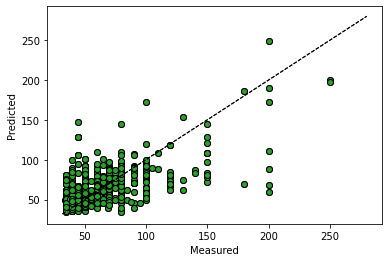

In [58]:
stack(for_train)

## Построение признаков

Попробуем добавить в датасет новые данные на основе уже существующих, которые смогут привнести в наши данные новые зависимости

In [59]:
for_train.columns

Index(['age', 'experience', 'population', 'gender_lbl',
       'position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom',
       'salary'],
      dtype='object')

In [63]:
for_train.columns[4:-1]

Index(['position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom'],
      dtype='object')

In [64]:
cat_data = for_train.iloc[:, :4]
cat_data['salary'] = for_train['salary']
# Реверсия категориальных признаков
cat_data['position'] = pd.get_dummies(for_train.iloc[:, 4:-1]).idxmax(1)

# Создание полиномиальных признаков
poly_data = cat_data.copy()
X = poly_data.drop(['salary'], axis=1)
y = poly_data['salary'].values

polynomial_features= PolynomialFeatures(degree=2)
X_poly = polynomial_features.fit_transform(X.drop(['position'], axis=1))
poly_data = pd.DataFrame(X_poly)
poly_data['salary'] = y

for i in for_train.columns[4:-1]:
  poly_data[i] = for_train[i]


poly_data.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,salary,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,1.0,0.0,5.0,11514330.0,0.0,0.0,0.0,0.0,0.0,25.0,57571650.0,0.0,1.325798e+14,0.0,0.0,37,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,53.0,10.0,1250615.0,0.0,2809.0,530.0,66282595.0,0.0,100.0,12506150.0,0.0,1.564038e+12,0.0,0.0,70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1.0,25.0,5.0,11514330.0,1.0,625.0,125.0,287858250.0,25.0,25.0,57571650.0,5.0,1.325798e+14,11514330.0,1.0,70,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,32.0,11.0,1143546.0,1.0,1024.0,352.0,36593472.0,32.0,121.0,12579006.0,11.0,1.307697e+12,1143546.0,1.0,50,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,43.0,7.0,111087.0,1.0,1849.0,301.0,4776741.0,43.0,49.0,777609.0,7.0,1.234032e+10,111087.0,1.0,40,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [65]:
poly_data.shape

(7250, 39)

In [ ]:
random_seed = 42

X = data_dummy.drop(['salary'], axis=1)
y = data_dummy['salary'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True,
    random_state=random_seed)

In [ ]:
X_test.columns

Index(['age', 'experience', 'population', 'gender_lbl',
       'position_Administrator', 'position_Voditel', 'position_Kam',
       'position_Kassir', 'position_Kladovsczik',
       'position_Klientskii_menedzher', 'position_Kommerczeskii_direktor',
       'position_Kurer', 'position_Menedzher_po_zakupkam',
       'position_Menedzher_po_prodazham', 'position_Menedzher_po_razvitiu',
       'position_Merczendaizer', 'position_Operator',
       'position_Pomoscznik_menedzhera', 'position_Prodaveckonsultant',
       'position_Regionalnyi_menedzher', 'position_Rukovoditel_prodazh',
       'position_Specialist', 'position_Supervaizer',
       'position_Territorialnyi_menedzher', 'position_Tovaroved',
       'position_Torgovyi_predstavitel', 'position_Upravljausczii_magazinom'],
      dtype='object')

In [66]:
test = X_test.copy()
test['salary'] = y_test

cat_test = test.iloc[:, :4]
cat_test['salary'] = test['salary']
# Реверсия категориальных признаков
cat_test['position'] = pd.get_dummies(test.iloc[:, 4:-1]).idxmax(1)

# Создание полиномиальных признаков
poly_data_test = cat_test.copy()
Xp = poly_data_test.drop(['salary'], axis=1)
yp = poly_data_test['salary'].values

polynomial_features= PolynomialFeatures(degree=2)
X_poly_test = polynomial_features.fit_transform(Xp.drop(['position'], axis=1))
poly_data_test = pd.DataFrame(X_poly_test)
poly_data_test['salary'] = yp

for i in test.columns[4:-1]:
  poly_data_test[i] = X_test[i].values

poly_data_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,salary,position_Administrator,position_Voditel,position_Kam,position_Kassir,position_Kladovsczik,position_Klientskii_menedzher,position_Kommerczeskii_direktor,position_Kurer,position_Menedzher_po_zakupkam,position_Menedzher_po_prodazham,position_Menedzher_po_razvitiu,position_Merczendaizer,position_Operator,position_Pomoscznik_menedzhera,position_Prodaveckonsultant,position_Regionalnyi_menedzher,position_Rukovoditel_prodazh,position_Specialist,position_Supervaizer,position_Territorialnyi_menedzher,position_Tovaroved,position_Torgovyi_predstavitel,position_Upravljausczii_magazinom
0,1.0,35.0,12.0,4848742.0,1.0,1225.0,420.0,169705970.0,35.0,144.0,58184904.0,12.0,2.351030e+13,4848742.0,1.0,90,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,34.0,13.0,991530.0,0.0,1156.0,442.0,33712020.0,0.0,169.0,12889890.0,0.0,9.831317e+11,0.0,0.0,50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1.0,44.0,17.0,1164896.0,0.0,1936.0,748.0,51255424.0,0.0,289.0,19803232.0,0.0,1.356983e+12,0.0,0.0,60,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.0,31.0,8.0,4848742.0,0.0,961.0,248.0,150311002.0,0.0,64.0,38789936.0,0.0,2.351030e+13,0.0,0.0,100,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1.0,26.0,5.0,80584.0,1.0,676.0,130.0,2095184.0,26.0,25.0,402920.0,5.0,6.493781e+09,80584.0,1.0,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [67]:
poly_data_test.shape

(634, 39)

In [68]:
X_test = poly_data_test.drop('salary', axis=1)
y_test = poly_data_test['salary'].values

[20:02:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE: 20.50220570729734 MAPE: 0.31984547090307514


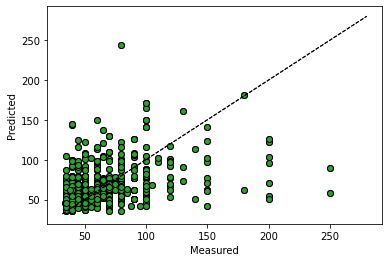

In [69]:
stack(poly_data)

Лучшие результаты показывает модель, полученная стекингом из трех моделей:
- XGBRegressor
- LGBMRegressor
- CatBoostRegressor

показывая результат лучше, чем BL

## Дорожная карта доработки

1) Повышение робастности модели за счет обогащения нескоррелированными данными, такими как:

- ключевые навыки
- тип предыдущего работодателя
- наличие водительских прав
- готовность к релокации и др.

2) Расширение тестируемых базовых алгоритмов

3) Использование NLP-алгоритмов для анализа резюме анкет

## Сериализация модели

In [ ]:
def serial_model(data):
  """Сохраняет модель регрессии в бинарный файл"""

  y_train = data['salary'].values
  X_train = data.drop(['salary'], axis=1)

  estimators = [
      ('XGBR', XGBRegressor(
          base_score=0.5, booster='gblinear', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.3, gamma=0,
          importance_type='gain', learning_rate=1, max_delta_step=0,
          max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
          n_jobs=1, nthread=None, objective='reg:squarederror',
          random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
          seed=None, silent=None, subsample=1, verbosity=1
      )),
      ('LGBM', LGBMRegressor(
          boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
          importance_type='split', learning_rate=0.1, max_depth=-1,
          min_child_samples=3, min_child_weight=0.001, min_split_gain=0.0,
          n_estimators=600, n_jobs=-1, num_leaves=5, objective='regression',
          random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
          subsample=1.0, subsample_for_bin=200000, subsample_freq=0
      )),
      ('CATR', CatBoostRegressor(random_state=random_seed, silent=True,
          boosting_type='Plain', bootstrap_type='MVS', iterations=1000, 
          l2_leaf_reg=3.0, leaf_estimation_iterations=10, 
          leaf_estimation_method='Gradient', learning_rate=0.1
      ))
  ]

  model = StackingRegressor(
      estimators=estimators,
      final_estimator=XGBRegressor(random_state=random_seed)
  )
      
  model.fit(X_train, y_train)
  

  # Сериализация модели
  with open(f'{wdir}/jsp_model.pkl', 'wb') as output:
    pickle.dump(model, output)

In [ ]:
serial_model(for_train)

In [ ]:
!pip freeze > requirements.txt

In [ ]:
!ls

drive  jsp_model.pkl  requirements.txt	sample_data
